In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd

%load_ext autoreload
%autoreload 2

In [2]:
if not (Path.cwd()/'gamesession.py').exists():  
    print('changing cwd')  
    os.chdir('..')
    Path.cwd()

from gamesession import GameSession

changing cwd


In [3]:
session = GameSession()

Game session data loaded
GameSession instance created


In [4]:
session.show_cast()

Player Info: 
    name           : Chris
    nbr_games_played: 0
    hosting_inclusion_list: []
    hosting_exclusion_list: ['Story-Story-Die']
    game_exclusion_list: []

Player Info: 
    name           : Etienne
    nbr_games_played: 0
    hosting_inclusion_list: []
    hosting_exclusion_list: ['Story-Story-Die']
    game_exclusion_list: []

Player Info: 
    name           : Knick
    nbr_games_played: 0
    hosting_inclusion_list: ['Story-Story-Die']
    hosting_exclusion_list: []
    game_exclusion_list: []

Player Info: 
    name           : Serena
    nbr_games_played: 0
    hosting_inclusion_list: []
    hosting_exclusion_list: ['Story-Story-Die']
    game_exclusion_list: []

Player Info: 
    name           : Yirong
    nbr_games_played: 0
    hosting_inclusion_list: []
    hosting_exclusion_list: ['Story-Story-Die']
    game_exclusion_list: []



## Experiment with drawing players

Options 1:

- weights $P_i = \large \frac{\text{factor}}{\text{sum of plays} + 1}$
- apply softmax to create probability, but exluding players not to play in that game
- randomly draw n players from that probability

Options 2:

- weights $P_i =  \exp{(- \lambda \times \text{ sum of plays})}$
- filtering out any player to exclude
- apply softmax to create probability, but exluding players not to play in that game
- randomly draw n players from that probability

The analysis below shows that the best is to use the 'linear' method with a factor = 25 to make probability of beeing picked for those players who played more than others much lower.

In [5]:
session = GameSession()
player_names = np.array([g.name for g in session.games])
n = np.argwhere(player_names=='Sure Ding').item()
session.games[n].name

Game session data loaded
GameSession instance created


'Sure Ding'

In [6]:
def test_pick(method, factor=1, l=0.5):
    results = pd.DataFrame(columns=[player.name for player in session.cast])
    total = 5_000
    for i in range(total):
        idxs, names = session.pick_players(session.games[n], method=method, factor=factor, l=l)
        played = np.zeros(session.nbr_players)
        played[idxs] = 1
        results.loc[i, :] = played
    results = results / total
    results.sum(axis=0).plot(kind='bar', title=f"{method}, factor={factor}, l={l}. playersgame: {results.sum().sum():.0f}")
    print(f"{results.sum(axis=0).min():.5f}, {results.sum(axis=0).max():.5f}")
    plt.show()

Linear with different factors

In [7]:
for nbr_played, player in zip([0, 1, 2, 3, 5], session.cast):
    player.nbr_games_played = nbr_played
[(p.name, p.nbr_games_played) for p in session.cast]

[('Chris', 0), ('Etienne', 1), ('Knick', 2), ('Serena', 3), ('Yirong', 5)]

0.47600, 0.80540


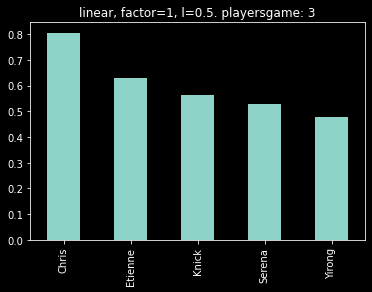

0.26280, 0.99880


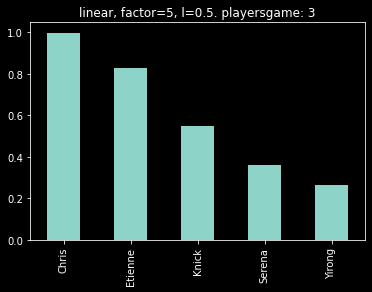

0.12900, 1.00000


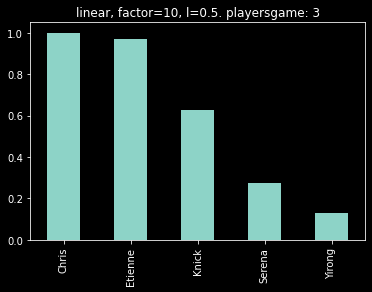

0.01280, 1.00000


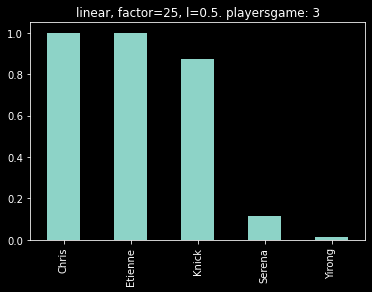

0.00040, 1.00000


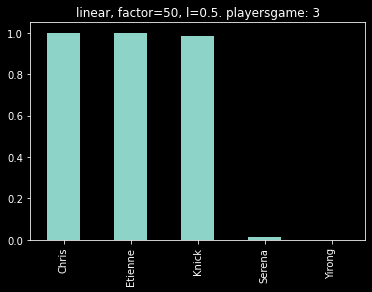

In [8]:
test_pick(method='linear', factor=1)
test_pick(method='linear', factor=5)
test_pick(method='linear', factor=10)
test_pick(method='linear', factor=25)
test_pick(method='linear', factor=50)

[('Chris', 3), ('Etienne', 3), ('Knick', 5), ('Serena', 5), ('Yirong', 6)]

0.57520, 0.63260


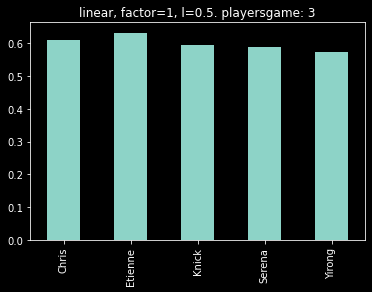

0.50240, 0.70180


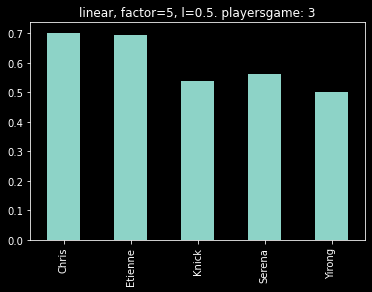

0.39260, 0.81160


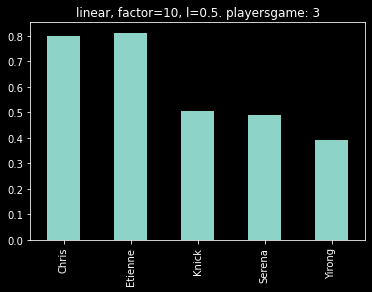

0.23200, 0.96480


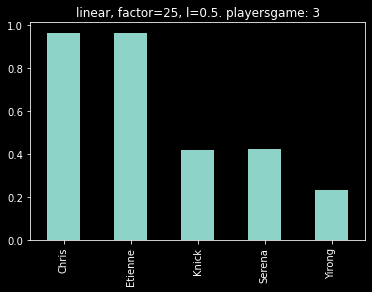

0.13760, 0.99960


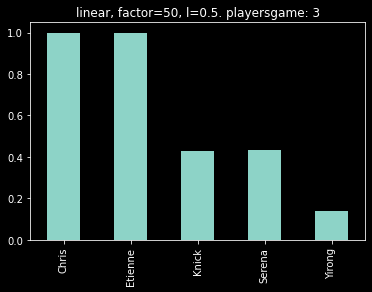

In [9]:
for nbr_played, player in zip([3, 3, 5, 5, 6], session.cast):
    player.nbr_games_played = nbr_played

display([(p.name, p.nbr_games_played) for p in session.cast])

test_pick(method='linear', factor=1)
test_pick(method='linear', factor=5)
test_pick(method='linear', factor=10)
test_pick(method='linear', factor=25)
test_pick(method='linear', factor=50)

Exponential

In [10]:
for nbr_played, player in zip([0, 1, 2, 3, 4], session.cast):
    player.nbr_games_played = nbr_played

display([(p.name, p.nbr_games_played) for p in session.cast])

[('Chris', 0), ('Etienne', 1), ('Knick', 2), ('Serena', 3), ('Yirong', 4)]

0.59100, 0.61220


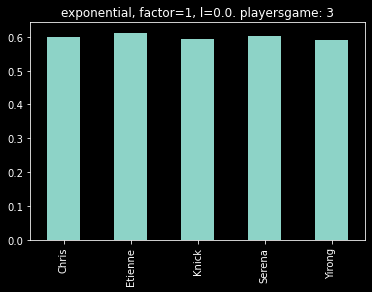

0.49220, 0.72600


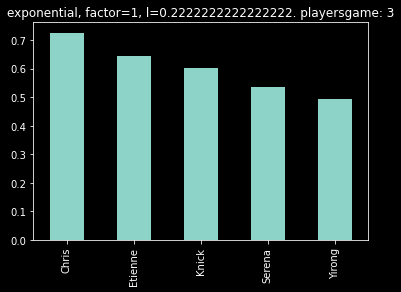

0.48820, 0.78300


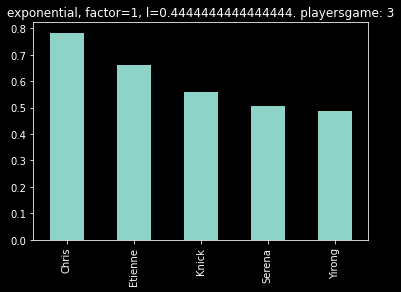

0.47440, 0.82580


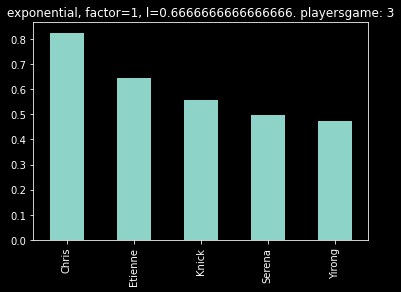

0.47060, 0.83100


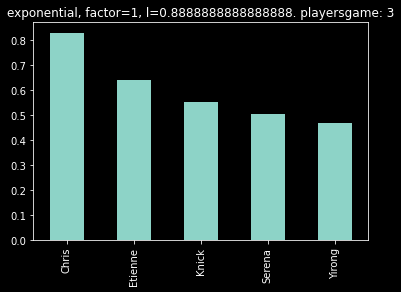

0.49200, 0.84020


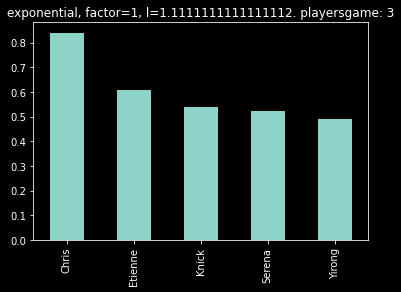

0.50320, 0.84900


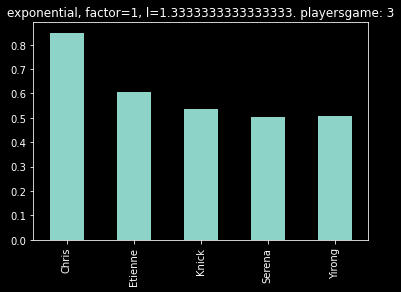

0.50880, 0.85820


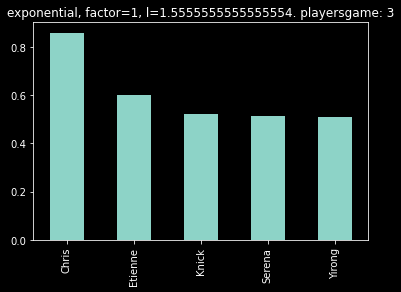

0.51860, 0.86360


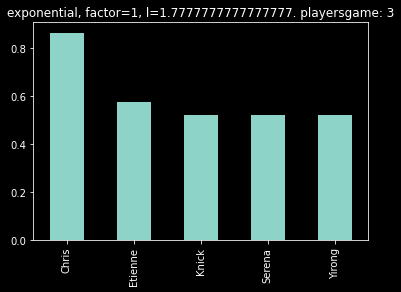

0.51360, 0.86000


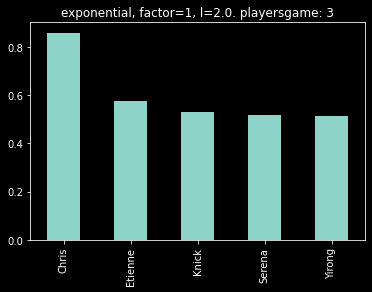

In [11]:
for l in np.linspace(0, 2, 10):
    test_pick(method='exponential', l=l)

[('Chris', 3), ('Etienne', 3), ('Knick', 5), ('Serena', 5), ('Yirong', 6)]

0.59620, 0.60320


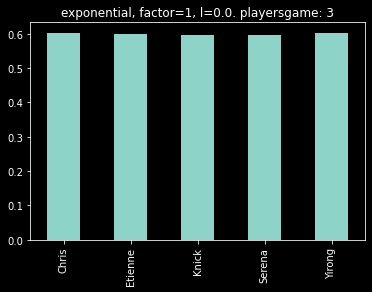

0.55640, 0.65180


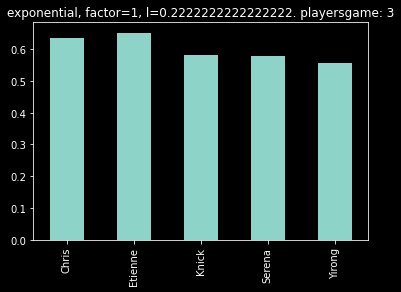

0.56540, 0.64060


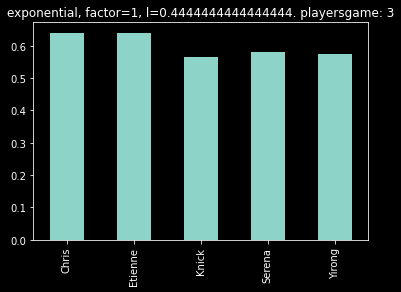

0.58080, 0.62380


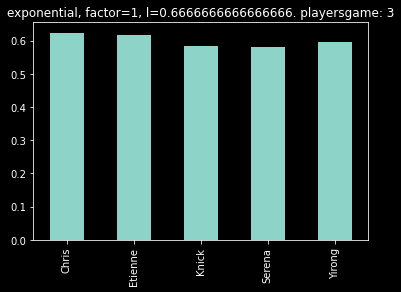

0.58320, 0.62260


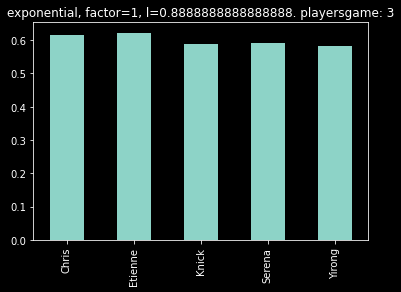

0.58620, 0.61560


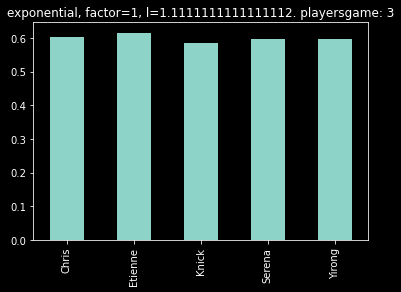

0.58160, 0.61340


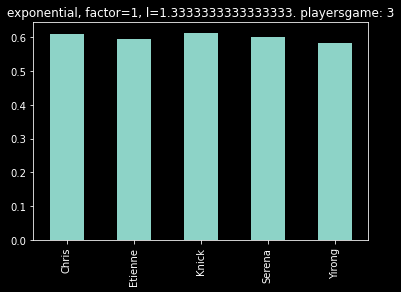

0.59520, 0.60680


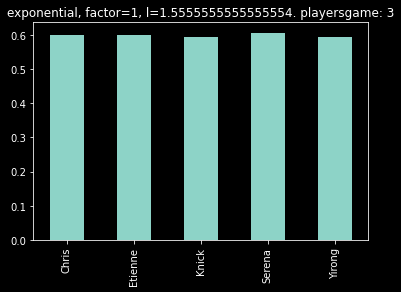

0.58500, 0.61100


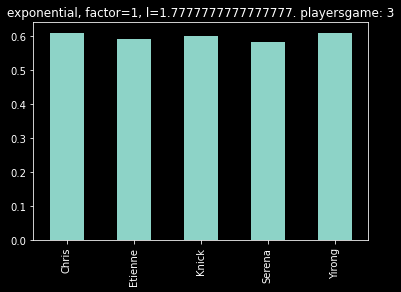

0.59240, 0.61080


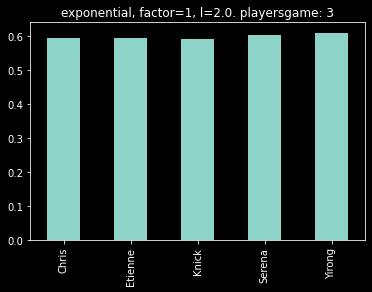

In [12]:
for nbr_played, player in zip([3, 3, 5, 5, 6], session.cast):
    player.nbr_games_played = nbr_played

display([(p.name, p.nbr_games_played) for p in session.cast])

for l in np.linspace(0, 2, 10):
    test_pick(method='exponential', l=l)